# Simulate QSO spectra.

The purpose of this notebook is to demonstrate how to simulate QSO spectra using [simqso](https://github.com/moustakas/simqso).  We also compare the results with the default (PCA-based) QSO template-generating code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
from desisim.templates import SIMQSO, QSO

In [3]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

#### Specify the random seed so the results are reproducible.

In [5]:
seed = 555
rand = np.random.RandomState(seed)

### Generate a handful of spectra using the default inputs and display them.

In [6]:
nmodel = 10

In [7]:
simqso = SIMQSO()

In [8]:
%time flux, wave, meta = simqso.make_templates(nmodel, seed=seed)

CPU times: user 6.05 s, sys: 76 ms, total: 6.12 s
Wall time: 6.24 s


In [9]:
def qaplot_handful(xlim=None):
    from matplotlib.ticker import FormatStrFormatter
    fig, ax1 = plt.subplots()
    for ii in range(nmodel):
        ax1.plot(wave, flux[ii, :])
    if xlim:
        ax1.set_xlim(xlim)
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax1.set_xlabel('Observed-Frame Wavelength ($\AA$)')
    ax1.set_ylabel(r'Flux ($10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$)')

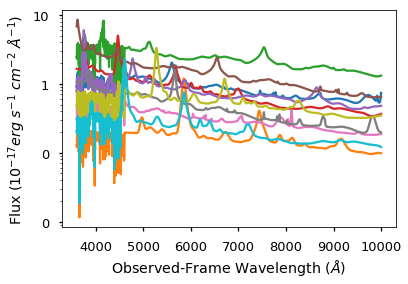

In [10]:
qaplot_handful()

### Now make more spectra with the redshift priors specified.

Turn off the Lyman-alpha forest for speed.

In [11]:
nmodel = 500
redshift = rand.uniform(2, 4, nmodel)

In [12]:
%time flux, wave, meta, qsometa = simqso.make_templates(nmodel, seed=seed, redshift=redshift, return_qsometa=True, lyaforest=False)

CPU times: user 14.8 s, sys: 291 ms, total: 15.1 s
Wall time: 15.3 s


In [13]:
def qaplot_props():
    bins = nmodel//15
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    _ = ax1.hist(meta['REDSHIFT'], bins=bins)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel('Number of Galaxies')
    
    _ = ax2.hist(meta['MAG'], bins=bins)
    ax2.set_xlabel(r'$r_{\rm DECaLS}$')
    
    _ = ax3.hist(qsometa['ABSMAG'], bins=bins)
    ax3.set_xlabel(r'$M_{1450}$')
    ax3.set_xlim(ax3.get_xlim()[::-1])
    plt.subplots_adjust(wspace=0.1)

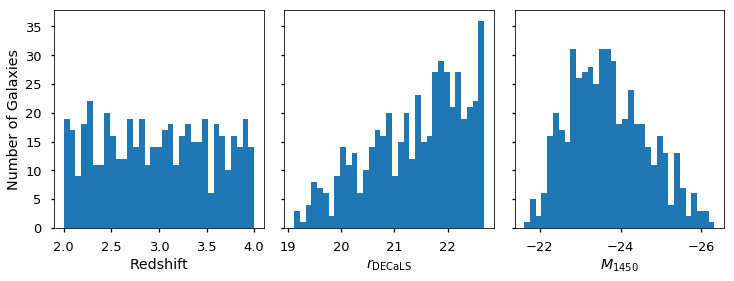

In [14]:
qaplot_props()

In [15]:
def qaplot_vsz():
    from matplotlib.ticker import MaxNLocator
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.scatter(meta['REDSHIFT'], meta['MAG'], edgecolor='k', alpha=0.9, s=50)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel(r'$r_{\rm DECaLS}$')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2.scatter(meta['REDSHIFT'], qsometa['ABSMAG'], edgecolor='k', alpha=0.9, s=50)
    ax2.set_ylabel(r'$M_{1450}$')
    ax2.set_xlabel('Redshift')
    ax2.set_ylim(ax2.get_ylim()[::-1])

    plt.subplots_adjust(wspace=0.3)

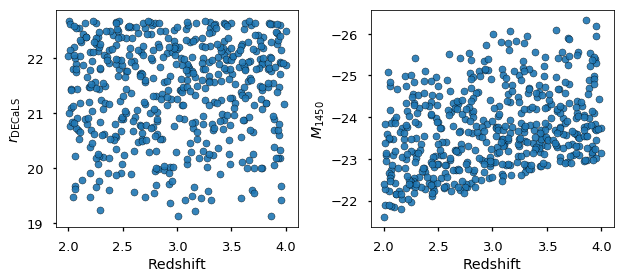

In [16]:
qaplot_vsz()

In [17]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    #with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
    #    warnings.simplefilter('ignore')
    colors['g'] = 22.5 - 2.5 * np.log10(cat['FLUX_G'])
    colors['r'] = 22.5 - 2.5 * np.log10(cat['FLUX_R'])
    colors['z'] = 22.5 - 2.5 * np.log10(cat['FLUX_Z'])
    colors['gr'] = colors['g'] - colors['r']
    colors['gz'] = colors['g'] - colors['z']
    colors['rz'] = colors['r'] - colors['z']
    colors['grz'] = 22.5-2.5*np.log10(cat['FLUX_G'] + 0.8 * cat['FLUX_R'] +  0.5 * cat['FLUX_G'] / 2.3)

    with np.errstate(invalid='ignore'):
        colors['W1'] = 22.5 - 2.5 * np.log10(cat['FLUX_W1'])
        colors['W2'] = 22.5 - 2.5 * np.log10(cat['FLUX_W2'])
        colors['W'] = 22.5 - 2.5 * np.log10(0.75 * cat['FLUX_W1'] + 0.25 * cat['FLUX_W2'])
        colors['rW'] = colors['r'] - colors['W']
        colors['W1W2'] = colors['W1'] - colors['W2']
        colors['grzW'] = colors['grz'] - colors['W']

    return colors

In [18]:
def qso_colorbox(ax, plottype='gr-rz', verts=None):
    """Draw the QSO selection boxes."""

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if plottype == 'gr-rz':
        verts = [(-0.3, 1.3),
                 (1.1, 1.3),
                 (1.1, ylim[0]-0.05),
                 (-0.3, ylim[0]-0.05)
                ]
    
    if plottype == 'r-W1W2':
        verts = None
        ax.axvline(x=22.7, ls='--', lw=2, color='k')
        ax.axhline(y=-0.4, ls='--', lw=2, color='k')
    
    if plottype == 'gz-grzW':
        gzaxis = np.linspace(-0.5, 2.0, 50)
        ax.plot(gzaxis, np.polyval([1.0, -1.0], gzaxis), 
                 ls='--', lw=2, color='k')

    if verts:
        ax.add_patch(Polygon(verts, fill=False, ls='--', lw=2, color='k'))

In [19]:
def qaplot_colorcolor():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ax1.scatter(colors['rz'], colors['gr'], edgecolor='k', alpha=0.9, s=20)
    ax1.set_xlabel('$r - z$')
    ax1.set_ylabel('$g - r$')
    ax1.set_xlim(-0.5, 1.5)
    ax1.set_ylim(-1.0, 1.5)
    qso_colorbox(ax1, 'gr-rz')
    
    ax2.scatter(colors['r'], colors['W1W2'], edgecolor='k', alpha=0.9, s=20)
    ax2.set_xlabel('$r$')
    ax2.set_ylabel('$W_{1} - W_{2}$')
    ax2.set_xlim(18, 23.5)
    ax2.set_ylim(-0.5, 1)
    qso_colorbox(ax2, 'r-W1W2')
    
    ax3.scatter(colors['gz'], colors['grzW'], edgecolor='k', alpha=0.9, s=20)
    ax3.set_xlabel('$g - z$')
    ax3.set_ylabel('$grz - W$')
    ax3.set_xlim(-1, 1.5)
    ax3.set_ylim(-1, 1.5)
    qso_colorbox(ax3, 'gz-grzW')


    plt.subplots_adjust(wspace=0.35)

In [20]:
colors = flux2colors(meta)

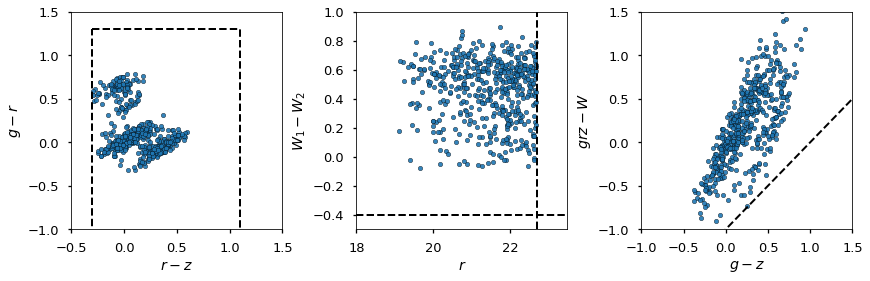

In [21]:
qaplot_colorcolor()

In [22]:
stop

NameError: name 'stop' is not defined

## Ignore below here --

In [ ]:
minwave, maxwave = 1000, 10e4

In [ ]:
nmodel = 20
redshift = rand.uniform(2, 4, nmodel)

#### Generate spectra using both SIMQSO() and QSO().

In [ ]:
simqso = SIMQSO(minwave=minwave, maxwave=maxwave, cdelt=2.0)

In [ ]:
%time flux, wave, meta = simqso.make_templates(nmodel, seed=seed, redshift=redshift, nocolorcuts=True)

In [ ]:
meta

In [ ]:
stop

In [ ]:
not True

In [ ]:
def plot_subset(nplot=12, ncol=4, xlim=None):
    """Plot a random sampling of the resulting templates."""
    
    if xlim is None:
        xlim = (minwave, maxwave)
    
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot, replace=False)
    these = np.sort(these)

    fig, ax = plt.subplots(nrow, ncol, figsize=(3*ncol, 2.5*nrow), sharey=False, sharex=True)
    for ii, (thisax, indx) in enumerate(zip(ax.flat, these)):
        thisax.plot(wave, flux[indx, :])
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        
        thisax.set_xlim(xlim)
        ww = (wave > xlim[0]) * (wave < xlim[1])
        ylim = (flux[indx, ww].min(), flux[indx, ww].max())
        thisax.set_ylim(ylim)
        thisax.set_yscale('log')
        thisax.set_xscale('log')
        
        thisax.yaxis.set_ticklabels([])
        #if xlim[1] > 1e4:
        #    thisax.set_xscale('log')
        #    thisax.set_yscale('log')
        #if ii == 0:
        #    thisax.legend(loc='upper left')
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [ ]:
plot_subset()

In [ ]:
stop

In [ ]:
qso = QSO(minwave=minwave, maxwave=maxwave, cdelt=2.0)

In [ ]:
%time qflux, _, qmeta = qso.make_templates(nmodel, seed=seed, redshift=meta['REDSHIFT'], mag=meta['MAG'], nocolorcuts=True)

In [ ]:
def compare_templates(nplot=12, ncol=4, xlim=None):
    """Plot a random sampling of the basis templates."""
    
    if xlim is None:
        xlim = (2500, 6000)
    
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot, replace=False)
    these = np.sort(these)

    fig, ax = plt.subplots(nrow, ncol, figsize=(3*ncol, 2.5*nrow), sharey=False, sharex=True)
    for ii, (thisax, indx) in enumerate(zip(ax.flat, these)):
        thisax.plot(wave, flux[indx, :], label='SIMQSO')
        thisax.plot(wave, qflux[indx, :], alpha=0.7, label='QSO')
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        thisax.set_xlim(xlim)
        ww = (wave > xlim[0]) * (wave < xlim[1])
        ylim = (flux[indx, ww].min(), flux[indx, ww].max())
        thisax.set_ylim(ylim)
        thisax.yaxis.set_ticklabels([])
        if xlim[1] > 1e4:
            thisax.set_xscale('log')
            thisax.set_yscale('log')
        if ii == 0:
            thisax.legend(loc='upper left')
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [ ]:
compare_templates()

In [ ]:
compare_templates(xlim=(6000, maxwave))

### Compare the two template sets in color-color and color-redshift space.

In [ ]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    #with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
    #    warnings.simplefilter('ignore')
    colors['g'] = 22.5 - 2.5 * np.log10(cat['FLUX_G'])
    colors['r'] = 22.5 - 2.5 * np.log10(cat['FLUX_R'])
    colors['z'] = 22.5 - 2.5 * np.log10(cat['FLUX_Z'])
    colors['gr'] = colors['g'] - colors['r']
    colors['gz'] = colors['g'] - colors['z']
    colors['rz'] = colors['r'] - colors['z']
    colors['grz'] = 22.5-2.5*np.log10(cat['FLUX_G'] + 0.8 * cat['FLUX_R'] +  0.5 * cat['FLUX_G'] / 2.3)

    with np.errstate(invalid='ignore'):
        colors['W'] = 22.5-2.5*np.log10(0.75 * cat['FLUX_W1'] + 0.25 * cat['FLUX_W2'])
        colors['rW'] = colors['r'] - colors['W']
    
    return colors

In [ ]:
colors = flux2colors(meta)
qcolors = flux2colors(qmeta)

In [ ]:
def qso_colorbox(ax, plottype='grz'):
    """Draw the QSO selection boxes."""
    rmaglim = 22.7
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if plottype == 'grz-r':
        verts = [(xlim[0]-0.05, 17.0),
                 (22.7, 17.0),
                 (22.7, ylim[1]+0.05),
                 (xlim[0]-0.05, ylim[1]+0.05)
                ]
    if plottype == 'rW1-rz':
        verts = None
        ax.axvline(x=-0.3, ls='--', color='k')
        ax.axvline(x=1.3, ls='--', color='k')

    if plottype == 'gr-rz':
        verts = [(-0.3, 1.3),
                 (1.1, 1.3),
                 (1.1, ylim[0]-0.05),
                 (-0.3, ylim[0]-0.05)
                ]
    if verts:
        ax.add_patch(Polygon(verts, fill=False, ls='--', color='k'))

In [ ]:
def qa_colorcolor():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.scatter(colors['rz'], colors['gr'], s=14, label='SIMQSO')
    ax1.scatter(qcolors['rz'], qcolors['gr'], s=14, label='QSO')
    ax1.set_xlabel('$r - z$')
    ax1.set_ylabel('$g - r$')
    ax1.set_xlim(-1, 2.2)
    ax1.set_ylim(-1, 2.0)
    ax1.legend(loc='upper right')
    qso_colorbox(ax1, 'gr-rz')
    
    ax2.scatter(colors['gz'], colors['rW'], s=14, label='SIMQSO')
    ax2.set_xlabel('$g - z$')
    ax2.set_ylabel('$r - W$')
    ax2.set_xlim(-0.3, 2)
    ax2.set_ylim(-1, 3)
    ax2.legend(loc='upper right')
    gzaxis = np.linspace(-0.5, 2.0, 50)
    ax2.plot(gzaxis, np.polyval([1.0, -1.0], gzaxis))
    #qso_colorbox(ax1, 'gr-rz')
    plt.subplots_adjust(wspace=0.3)

In [ ]:
qa_colorcolor()

In [ ]:
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)
nqso = 10
np.random.seed(12345)
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
sedVars = get_BossDr9_model_vars(qsos,wave,0,noforest=True)

In [ ]:
subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
                               name='sublimdust')
hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
                               name='hotdust')

In [ ]:
subDustVar.set_associated_var(sedVars[0])
#hotDustVar.set_associated_var(contVar)

In [ ]:
sedVars

In [ ]:
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
wave = sqbase.fixed_R_dispersion(500,20e4,1000)
nqso = 10
np.random.seed(12345)
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=1,gridseed=1)

sedVars = get_BossDr9_model_vars(qsos,wave,noforest=False)
subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
                               name='sublimdust')
hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
                               name='hotdust')
subDustVar.set_associated_var(sedVars[0])
hotDustVar.set_associated_var(sedVars[0])
    
qsos.addVars(sedVars)

qsos.loadPhotoMap([('DECam', 'DECaLS'), ('WISE', 'AllWISE')])
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3)

# do it again
sedVars = get_BossDr9_model_vars(qsos,wave,noforest=False)
subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
                               name='sublimdust')
hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
                               name='hotdust')
subDustVar.set_associated_var(sedVars[0])
hotDustVar.set_associated_var(sedVars[0])
    
qsos.addVars(sedVars)

qsos.loadPhotoMap([('DECam', 'DECaLS'), ('WISE', 'AllWISE')])
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3)

